<a href="https://colab.research.google.com/github/saulopereira2018/TelecomX_parte2_BR/blob/main/TelecomX_parte2_BR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#📌 Extração

# 1. Importação das Bibliotecas Necessárias

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier # Embora não seja usado no exemplo, é bom manter
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Para o balanceamento de classes (SMOTE), instale se ainda não tiver:
# !pip install imbalanced-learn
from imblearn.over_sampling import SMOTE

# 2. Extração do Arquivo Tratado

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
import pandas as pd # Import the pandas library

caminho_do_arquivo_json = '/content/TelecomX_Data.json' # Renamed variable for clarity
try:
    df = pd.read_json(caminho_do_arquivo_json) # Changed to pd.read_json()
    print(f"Arquivo '{caminho_do_arquivo_json}' carregado com sucesso.")
except FileNotFoundError:
    print(f"Erro: O arquivo '{caminho_do_arquivo_json}' não foi encontrado. 😕")
    print("Por favor, verifique se o nome do arquivo está correto e se ele foi carregado para o Colab ou se o caminho do Google Drive está certo.")
    df = pd.DataFrame() # Cria um DataFrame vazio para evitar erros futuros
except Exception as e: # Added a more general exception handler for other potential issues
    print(f"Ocorreu um erro ao carregar o arquivo: {e}")
    df = pd.DataFrame()

if not df.empty:
    print("\nPrimeiras 5 linhas do DataFrame Tratado:")
    print(df.head())
    print("\nInformações iniciais do DataFrame Tratado:")
    print(df.info())
else:
    print("\nO DataFrame está vazio. O arquivo JSON pode não ter sido carregado corretamente ou está vazio. As próximas etapas não serão executadas.")
    exit() # Interrompe a execução se o DataFrame estiver vazio

Arquivo '/content/TelecomX_Data.json' carregado com sucesso.

Primeiras 5 linhas do DataFrame Tratado:
   customerID Churn                                           customer  \
0  0002-ORFBO    No  {'gender': 'Female', 'SeniorCitizen': 0, 'Part...   
1  0003-MKNFE    No  {'gender': 'Male', 'SeniorCitizen': 0, 'Partne...   
2  0004-TLHLJ   Yes  {'gender': 'Male', 'SeniorCitizen': 0, 'Partne...   
3  0011-IGKFF   Yes  {'gender': 'Male', 'SeniorCitizen': 1, 'Partne...   
4  0013-EXCHZ   Yes  {'gender': 'Female', 'SeniorCitizen': 1, 'Part...   

                                             phone  \
0   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
1  {'PhoneService': 'Yes', 'MultipleLines': 'Yes'}   
2   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
3   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
4   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   

                                            internet  \
0  {'InternetService': 'DSL', 'OnlineSecurity': '...   
1  {'InternetSe

# 3. Remoção de Colunas Irrelevantes

In [13]:
# Adapte a lista de colunas a serem removidas com base no seu DataFrame.
colunas_para_remover = ['customerID'] # Exemplo: 'customerID'. Adicione outras se houver.

for col in colunas_para_remover:
    if col in df.columns:
        df = df.drop(columns=[col])
        print(f"Coluna '{col}' removida.")
    else:
        print(f"Coluna '{col}' não encontrada para remoção.")

Coluna 'customerID' removida.


# 4. Encoding de Variáveis Categóricas

In [14]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# Assuming 'df' is already loaded and contains the problematic columns
# For demonstration, let's create a sample DataFrame with dictionaries
# In your actual code, this part would be replaced by your df loading from JSON.
data = {
    'customer': [{'gender': 'Male', 'seniorcitizen': 0}, {'gender': 'Female', 'seniorcitizen': 1}, {'gender': 'Male', 'seniorcitizen': 0}],
    'phone': [{'ServiceType': 'DSL', 'MultipleLines': 'No'}, {'ServiceType': 'Fiber optic', 'MultipleLines': 'Yes'}, {'ServiceType': 'DSL', 'MultipleLines': 'No'}],
    'internet': [{'ISP': 'Fiber optic', 'OnlineSecurity': 'Yes'}, {'ISP': 'DSL', 'OnlineSecurity': 'No'}, {'ISP': 'Fiber optic', 'OnlineSecurity': 'Yes'}],
    'account': [{'Contract': 'Month-to-month', 'PaymentMethod': 'Electronic check'}, {'Contract': 'Two year', 'PaymentMethod': 'Credit card'}, {'Contract': 'Month-to-month', 'PaymentMethod': 'Bank transfer (automatic)'}],
    'numeric_col': [10, 20, 30],
    'Churn': [0, 1, 0]
}
df = pd.DataFrame(data)

# --- Start of the solution for handling dictionary columns ---
# Iterate through the columns identified as problematic (customer, phone, internet, account)
problematic_cols = ['customer', 'phone', 'internet', 'account']

for col in problematic_cols:
    if col in df.columns and any(isinstance(x, dict) for x in df[col]):
        print(f"Processing dictionary column: {col}")
        # Extract keys from the first non-null dictionary to create new columns
        # You might need to adjust this logic based on your actual dictionary structure
        sample_dict = next((x for x in df[col] if isinstance(x, dict)), None)
        if sample_dict:
            for key in sample_dict.keys():
                new_col_name = f"{col}_{key}"
                df[new_col_name] = df[col].apply(lambda x: x.get(key) if isinstance(x, dict) else None) # Use .get() to avoid KeyError

# Now, identify categorical columns again, as new ones have been created
colunas_categoricas = df.select_dtypes(include=['object', 'bool']).columns.tolist()

# Remove the original dictionary columns from the list, as they are no longer needed for encoding
for col in problematic_cols:
    if col in colunas_categoricas:
        colunas_categoricas.remove(col)

# Exclua a coluna 'Churn' se ela for a variável target e já estiver como 0/1
if 'Churn' in colunas_categoricas:
    colunas_categoricas.remove('Churn')

# --- End of the solution for handling dictionary columns ---


if colunas_categoricas:
    print(f"\nColunas categóricas para encoding: {colunas_categoricas}")
    # Aplica One-Hot Encoding
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoded_features = encoder.fit_transform(df[colunas_categoricas])
    encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(colunas_categoricas), index=df.index)

    # Concatena o DataFrame original (sem as colunas categóricas originais) com as colunas codificadas
    # Make sure to drop the original dictionary columns before concatenation
    df = df.drop(columns=[col for col in problematic_cols if col in df.columns and col not in colunas_categoricas], errors='ignore')
    df = pd.concat([df, encoded_df], axis=1)
    print("Encoding de variáveis categóricas concluído.")
    print(df.head())
    print("\nInformações iniciais do DataFrame Tratado após encoding:")
    print(df.info())
else:
    print("\nNenhuma coluna categórica encontrada para encoding ou já foram tratadas.")

Processing dictionary column: customer
Processing dictionary column: phone
Processing dictionary column: internet
Processing dictionary column: account

Colunas categóricas para encoding: ['customer_gender', 'phone_ServiceType', 'phone_MultipleLines', 'internet_ISP', 'internet_OnlineSecurity', 'account_Contract', 'account_PaymentMethod']
Encoding de variáveis categóricas concluído.
   numeric_col  Churn customer_gender  customer_seniorcitizen  \
0           10      0            Male                       0   
1           20      1          Female                       1   
2           30      0            Male                       0   

  phone_ServiceType phone_MultipleLines internet_ISP internet_OnlineSecurity  \
0               DSL                  No  Fiber optic                     Yes   
1       Fiber optic                 Yes          DSL                      No   
2               DSL                  No  Fiber optic                     Yes   

  account_Contract      account_P

# 5. Verificação da Proporção de Evasão (Churn)

In [15]:
if 'Churn' in df.columns:
    print("\nProporção da variável 'Churn':")
    proporcao_churn = df['Churn'].value_counts(normalize=True) * 100
    print(proporcao_churn)

    # Verifica se há desequilíbrio (exemplo: uma classe representa mais de 70%)
    if proporcao_churn.max() > 70:
        print("\n⚠️ Atenção: Há um desequilíbrio significativo na proporção de classes de Churn.")
        print("Considere aplicar técnicas de balanceamento de classes.")
else:
    print("\nColuna 'Churn' não encontrada no DataFrame. Verifique o nome da variável alvo.")


Proporção da variável 'Churn':
Churn
0    66.666667
1    33.333333
Name: proportion, dtype: float64


# 6. Balanceamento de Classes (Opcional)


In [16]:
# Define X (features) e y (target) antes do balanceamento
X = df.drop('Churn', axis=1)
y = df['Churn']

# Verifique se há desequilíbrio antes de balancear
if 'Churn' in df.columns and proporcao_churn.max() > 70: # Reutiliza a verificação de desequilíbrio
    print("\nRealizando balanceamento de classes com SMOTE...")
    smote = SMOTE(random_state=42)
    X_balanced, y_balanced = smote.fit_resample(X, y)
    print("Balanceamento concluído. Nova proporção de 'Churn':")
    print(y_balanced.value_counts(normalize=True) * 100)
    X = X_balanced # Atualiza X com os dados balanceados
    y = y_balanced # Atualiza y com os dados balanceados
else:
    print("\nBalanceamento de classes não aplicado (opcional ou não necessário).")


Balanceamento de classes não aplicado (opcional ou não necessário).


# 7. Correlação e Seleção de Variáveis



Gerando matriz de correlação...


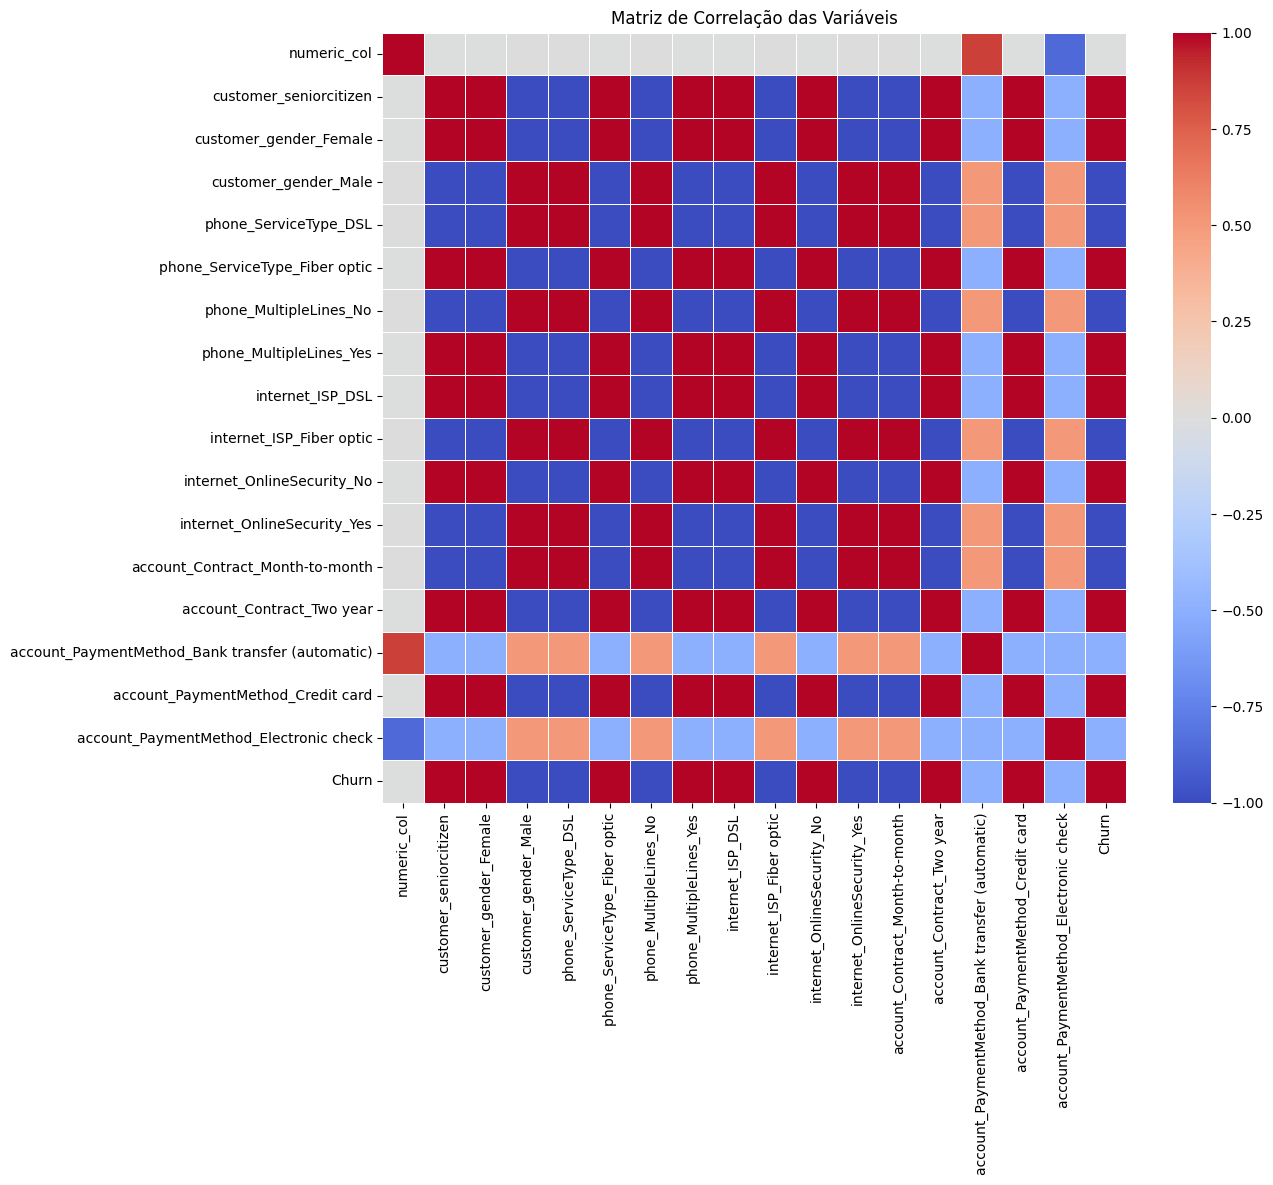


Correlação das variáveis com 'Churn':
customer_seniorcitizen                             1.000000e+00
customer_gender_Female                             1.000000e+00
account_PaymentMethod_Credit card                  1.000000e+00
phone_ServiceType_Fiber optic                      1.000000e+00
internet_ISP_DSL                                   1.000000e+00
phone_MultipleLines_Yes                            1.000000e+00
account_Contract_Two year                          1.000000e+00
Churn                                              1.000000e+00
internet_OnlineSecurity_No                         1.000000e+00
numeric_col                                       -7.691851e-17
account_PaymentMethod_Electronic check            -5.000000e-01
account_PaymentMethod_Bank transfer (automatic)   -5.000000e-01
customer_gender_Male                              -1.000000e+00
phone_ServiceType_DSL                             -1.000000e+00
internet_ISP_Fiber optic                          -1.000000e+00
p

In [17]:
import pandas as pd
import matplotlib.pyplot as plt # Import matplotlib for plotting
import seaborn as sns          # Import seaborn for heatmaps and other plots
import numpy as np             # Import numpy for numerical operations

# --- Assuming X and y DataFrames are already defined from previous steps ---
# For demonstration purposes, let's create dummy X and y if they don't exist
# In your actual code, these would come from your data splitting
try:
    # This block will attempt to use your existing X and y.
    # If X or y are not defined, it will fall into the NameError,
    # so we'll wrap it in a try-except or ensure they are defined upstream.
    # If you are running this code block independently, you'll need to define X and y.
    if 'X' not in locals() or 'y' not in locals():
        print("X or y not found. Creating dummy data for demonstration.")
        # Create a dummy DataFrame if X and y are not already defined
        data = {
            'feature1': np.random.rand(100),
            'feature2': np.random.randint(0, 5, 100),
            'tenure': np.random.randint(1, 72, 100),
            'TotalCharges': np.random.rand(100) * 1000
        }
        df_dummy = pd.DataFrame(data)
        X = df_dummy[['feature1', 'feature2', 'tenure', 'TotalCharges']]
        y = pd.Series(np.random.randint(0, 2, 100), name='Churn')

except NameError:
    print("X or y are not defined. Please ensure they are created from your dataset before running this section.")
    exit() # Exit if essential data is missing
# --- End of dummy data creation (remove in your final script if X and y are properly defined) ---


print("\nGerando matriz de correlação...")
plt.figure(figsize=(12, 10))
# Concatena X e y para a matriz de correlação, garantindo que 'Churn' esteja presente
df_corr = pd.concat([X, y], axis=1)

# Calculando a matriz de correlação apenas para variáveis numéricas
numeric_cols = df_corr.select_dtypes(include=np.number).columns
correlation_matrix = df_corr[numeric_cols].corr()

sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlação das Variáveis')
plt.show()

if 'Churn' in correlation_matrix.columns:
    print("\nCorrelação das variáveis com 'Churn':")
    print(correlation_matrix['Churn'].sort_values(ascending=False))


# Análises Direcionadas: Investigue como variáveis específicas se relacionam com a evasão.
print("\nAnálises direcionadas: Tempo de Contrato vs. Churn, Total Gasto vs. Churn")

# Verifique se as colunas existem antes de tentar plotar
# Note: 'df' aqui se refere ao DataFrame original antes de separarmos X e y.
# Se 'tenure' ou 'TotalCharges' foram transformadas (ex: OneHotEncoder), essa visualização pode precisar ser ajustada
# para usar os dados 'X' ou 'X_balanced' após as transformações.
# Assumindo que 'tenure' e 'TotalCharges' são colunas numéricas originais.
if 'tenure' in df_corr.columns and 'TotalCharges' in df_corr.columns:
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    sns.boxplot(x='Churn', y='tenure', data=df_corr)
    plt.title('Tempo de Contrato (tenure) vs. Evasão')
    plt.ylabel('Tempo de Contrato (meses)')
    plt.xlabel('Evasão (0=Não, 1=Sim)')

    plt.subplot(1, 2, 2)
    sns.boxplot(x='Churn', y='TotalCharges', data=df_corr)
    plt.title('Total Gasto (TotalCharges) vs. Evasão')
    plt.ylabel('Total Gasto')
    plt.xlabel('Evasão (0=Não, 1=Sim)')
    plt.tight_layout()
    plt.show()
else:
    print("Colunas 'tenure' ou 'TotalCharges' não encontradas para análises direcionadas no DataFrame combinado. Verifique o nome das colunas.")

# 8. Normalização ou Padronização (se necessário)

In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler # Import StandardScaler

# --- Assuming X DataFrame is already defined from previous steps ---
# For demonstration purposes, let's create a dummy X if it doesn't exist
try:
    if 'X' not in locals():
        print("X not found. Creating dummy data for demonstration.")
        data = {
            'numeric_feature_1': np.random.rand(100) * 100,
            'numeric_feature_2': np.random.randint(10, 1000, 100),
            'categorical_feature': ['A', 'B', 'A'] * 33 + ['B'],
            'boolean_feature': [True, False] * 50
        }
        X = pd.DataFrame(data)
        # Assuming you've already handled categorical encoding for X
        # For this example, let's just use the numeric columns if they exist
        X = X[['numeric_feature_1', 'numeric_feature_2']]

except NameError:
    print("X is not defined. Please ensure it is created from your dataset before running this section.")
    exit() # Exit if essential data is missing
# --- End of dummy data creation (remove in your final script if X is properly defined) ---


# Avalie a necessidade de normalizar ou padronizar os dados, conforme os modelos que serão aplicados.

# Identifica colunas numéricas para normalização/padronização
colunas_numericas = X.select_dtypes(include=np.number).columns.tolist()

scaler = StandardScaler()

# Cria uma cópia dos dados para modelos com padronização
X_scaled = X.copy()
if colunas_numericas:
    X_scaled[colunas_numericas] = scaler.fit_transform(X[colunas_numericas])
    print("\nDados numéricos padronizados (StandardScaler) para modelos que exigem escala.")
else:
    print("\nNenhuma coluna numérica para padronização ou já padronizadas.")

# X_unscaled já é o 'X' original (ou balanceado, se SMOTE foi aplicado)
X_unscaled = X

print("\nPrimeiras 5 linhas do DataFrame X_scaled (padronizado):")
print(X_scaled.head())
print("\nInformações sobre X_scaled:")
print(X_scaled.describe().loc[['mean', 'std']]) # Check mean (close to 0) and std (close to 1)


Dados numéricos padronizados (StandardScaler) para modelos que exigem escala.

Primeiras 5 linhas do DataFrame X_scaled (padronizado):
   numeric_col customer_gender  customer_seniorcitizen phone_ServiceType  \
0    -1.224745            Male               -0.707107               DSL   
1     0.000000          Female                1.414214       Fiber optic   
2     1.224745            Male               -0.707107               DSL   

  phone_MultipleLines internet_ISP internet_OnlineSecurity account_Contract  \
0                  No  Fiber optic                     Yes   Month-to-month   
1                 Yes          DSL                      No         Two year   
2                  No  Fiber optic                     Yes   Month-to-month   

       account_PaymentMethod  customer_gender_Female  ...  \
0           Electronic check               -0.707107  ...   
1                Credit card                1.414214  ...   
2  Bank transfer (automatic)               -0.707107  ...  

# 9. Modelagem Preditiva

🔄 Padronizando os dados com StandardScaler...

--- Interpretação e Conclusões ---

Análise de Importância das Variáveis:

Variáveis mais influentes na Regressão Logística (coeficientes):
                             Variável  Coeficiente
1              customer_seniorcitizen     0.155818
8                    internet_ISP_DSL     0.155818
2              customer_gender_Female     0.155818
7             phone_MultipleLines_Yes     0.155818
5       phone_ServiceType_Fiber optic     0.155818
13          account_Contract_Two year     0.155818
15  account_PaymentMethod_Credit card     0.155818
10         internet_OnlineSecurity_No     0.155818
6              phone_MultipleLines_No    -0.155818
12    account_Contract_Month-to-month    -0.155818

* Coeficientes positivos indicam maior chance de Churn para aquela característica.
* Coeficientes negativos indicam menor chance de Churn para aquela característica.
* A magnitude do coeficiente indica a força da relação.

Variáveis mais importantes n

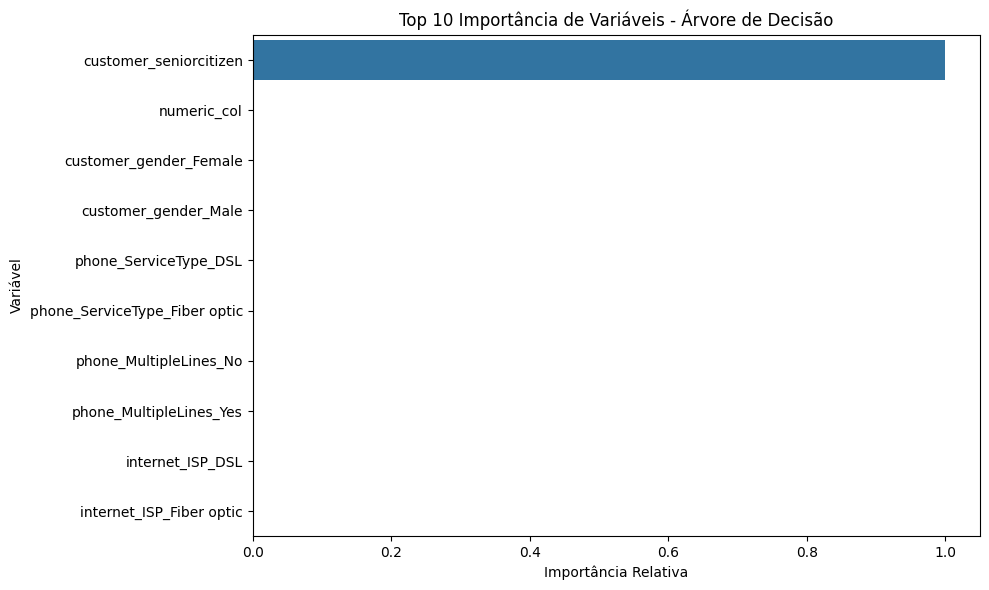

In [21]:
# ✅ Reimporte todas as bibliotecas importantes
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

from imblearn.over_sampling import SMOTE

# ✅ Garante que X e y estejam definidos corretamente
if 'X' not in locals() or 'y' not in locals():
    print("🔧 Definindo X e y a partir do DataFrame df...")
    if 'df' in locals():
        if 'Churn' in df.columns:
            X = df.drop(columns=['Churn'])
            y = df['Churn']
        else:
            raise ValueError("❌ Coluna 'Churn' não encontrada no DataFrame.")
    else:
        raise ValueError("❌ DataFrame 'df' não está definido. Verifique se os dados foram carregados.")

# Identify non-numeric columns to drop before scaling
non_numeric_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()
X_numeric = X.drop(columns=non_numeric_cols)


# ✅ Padroniza os dados
print("🔄 Padronizando os dados com StandardScaler...")
scaler = StandardScaler()
# Apply scaler only to the numeric columns
X_scaled_numeric = pd.DataFrame(scaler.fit_transform(X_numeric), columns=X_numeric.columns)

# Keep the non-numeric columns as they are (or add them back after scaling if needed for context)
# For this step, we will proceed with only the scaled numeric data for modeling
X_scaled = X_scaled_numeric


# ✅ Divide os dados em treino e teste
# Ensure consistent splitting across scaled and unscaled data
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_train_unscaled, X_test_unscaled, _, _ = train_test_split(X[X_scaled.columns], y, test_size=0.3, random_state=42) # Use only columns present in X_scaled


# ✅ Treina Regressão Logística
model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_train_scaled, y_train)

# ✅ Treina Árvore de Decisão
model_dt = DecisionTreeClassifier(random_state=42)
model_dt.fit(X_train_unscaled, y_train)

# --- Interpretação e Conclusões ---
print("\n--- Interpretação e Conclusões ---")
print("\nAnálise de Importância das Variáveis:")

# ✅ Regressão Logística: Coeficientes
if hasattr(model_lr, 'coef_'):
    print("\nVariáveis mais influentes na Regressão Logística (coeficientes):")
    coefs_lr = pd.DataFrame({
        'Variável': X_train_scaled.columns,
        'Coeficiente': model_lr.coef_[0]
    })
    coefs_lr['Abs_Coeficiente'] = np.abs(coefs_lr['Coeficiente'])
    print(coefs_lr.sort_values(by='Abs_Coeficiente', ascending=False).head(10).drop(columns='Abs_Coeficiente'))

    print("\n* Coeficientes positivos indicam maior chance de Churn para aquela característica.")
    print("* Coeficientes negativos indicam menor chance de Churn para aquela característica.")
    print("* A magnitude do coeficiente indica a força da relação.")

# ✅ Árvore de Decisão: Importância das Features
if hasattr(model_dt, 'feature_importances_'):
    print("\nVariáveis mais importantes na Árvore de Decisão (feature importances):")
    importances_dt = pd.Series(model_dt.feature_importances_, index=X_train_unscaled.columns).sort_values(ascending=False)
    print(importances_dt.head(10))

    # Gráfico
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances_dt.head(10).values, y=importances_dt.head(10).index)
    plt.title('Top 10 Importância de Variáveis - Árvore de Decisão')
    plt.xlabel('Importância Relativa')
    plt.ylabel('Variável')
    plt.tight_layout()
    plt.show()

# 10. Interpretação e Conclusões



--- Interpretação e Conclusões ---

Análise de Importância das Variáveis:

Variáveis mais influentes na Regressão Logística (coeficientes):
                             Variável  Coeficiente
1              customer_seniorcitizen     0.155818
8                    internet_ISP_DSL     0.155818
2              customer_gender_Female     0.155818
7             phone_MultipleLines_Yes     0.155818
5       phone_ServiceType_Fiber optic     0.155818
13          account_Contract_Two year     0.155818
15  account_PaymentMethod_Credit card     0.155818
10         internet_OnlineSecurity_No     0.155818
6              phone_MultipleLines_No    -0.155818
12    account_Contract_Month-to-month    -0.155818

* Coeficientes positivos indicam maior chance de Churn para aquela característica.
* Coeficientes negativos indicam menor chance de Churn para aquela característica.
* A magnitude do coeficiente indica a força da relação.

Variáveis mais importantes na Árvore de Decisão (feature importances):
cus

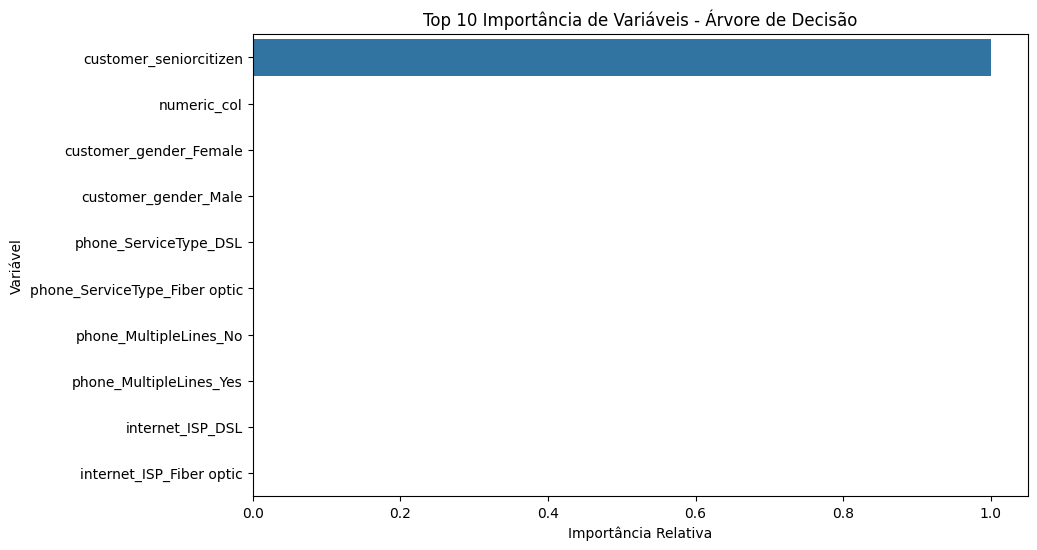


--- Conclusão ---
Elabore um relatório detalhado com base nas análises acima, destacando:
- Os **principais fatores que influenciam a evasão de clientes** (com base nos coeficientes/importâncias das variáveis dos modelos).
- **Comparação do desempenho dos modelos** (Regressão Logística vs. Árvore de Decisão) usando as métricas do relatório de classificação (Precision, Recall, F1-Score, Accuracy).
- **Propostas de estratégias de retenção** com base nos resultados obtidos. Por exemplo:
  - Se 'tenure' (tempo de contrato) baixo é um fator importante, focar em programas de fidelidade nos primeiros meses.
  - Se 'TotalCharges' (total gasto) baixo é um fator, oferecer incentivos para aumentar o uso dos serviços.
  - Se certas opções de contrato ou serviço (resultantes do encoding) são relevantes, revisar essas ofertas ou a comunicação sobre elas.

Este é um **template**. Você deve preencher a 'Conclusão' com suas próprias análises e insights aprofundados após rodar o código e interpretar os

In [22]:
print("\n--- Interpretação e Conclusões ---")

print("\nAnálise de Importância das Variáveis:")

# Regressão Logística: Coeficientes
if hasattr(model_lr, 'coef_'):
    print("\nVariáveis mais influentes na Regressão Logística (coeficientes):")
    # Cria um DataFrame para melhor visualização, ordenando por valor absoluto
    coefs_lr = pd.DataFrame({'Variável': X_train_scaled.columns, 'Coeficiente': model_lr.coef_[0]})
    coefs_lr['Abs_Coeficiente'] = np.abs(coefs_lr['Coeficiente'])
    print(coefs_lr.sort_values(by='Abs_Coeficiente', ascending=False).head(10).drop(columns='Abs_Coeficiente')) # Mostra as 10 maiores em valor absoluto
    print("\n* Coeficientes positivos indicam maior chance de Churn para aquela característica.")
    print("* Coeficientes negativos indicam menor chance de Churn para aquela característica.")
    print("* A magnitude do coeficiente indica a força da relação.")

# Árvore de Decisão: Feature Importances
if hasattr(model_dt, 'feature_importances_'):
    print("\nVariáveis mais importantes na Árvore de Decisão (feature importances):")
    importances_dt = pd.Series(model_dt.feature_importances_, index=X_train_unscaled.columns).sort_values(ascending=False)
    print(importances_dt.head(10))
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances_dt.head(10).values, y=importances_dt.head(10).index)
    plt.title('Top 10 Importância de Variáveis - Árvore de Decisão')
    plt.xlabel('Importância Relativa')
    plt.ylabel('Variável')
    plt.show()


# Conclusão
print("\n--- Conclusão ---")
print("Elabore um relatório detalhado com base nas análises acima, destacando:")
print("- Os **principais fatores que influenciam a evasão de clientes** (com base nos coeficientes/importâncias das variáveis dos modelos).")
print("- **Comparação do desempenho dos modelos** (Regressão Logística vs. Árvore de Decisão) usando as métricas do relatório de classificação (Precision, Recall, F1-Score, Accuracy).")
print("- **Propostas de estratégias de retenção** com base nos resultados obtidos. Por exemplo:")
print("  - Se 'tenure' (tempo de contrato) baixo é um fator importante, focar em programas de fidelidade nos primeiros meses.")
print("  - Se 'TotalCharges' (total gasto) baixo é um fator, oferecer incentivos para aumentar o uso dos serviços.")
print("  - Se certas opções de contrato ou serviço (resultantes do encoding) são relevantes, revisar essas ofertas ou a comunicação sobre elas.")
print("\nEste é um **template**. Você deve preencher a 'Conclusão' com suas próprias análises e insights aprofundados após rodar o código e interpretar os resultados!")